# Happy Customers - An Apziva Project

By Samuel Alter

## Project Overview

This project centers on a customer survey dataset from a delivery company. The dataset consists of survey responses, ranked on a 1 to 5 scale, with 5 indicating most agreement with the following statements:
* `X1`: Order was delivered on time
* `X2`: Contents of the order was as expected 
> Think: after the order has been delivered
* `X3`: I ordered everything that I wanted to order 
> Think: while placing the order
* `X4`: I paid a good price for my order
* `X5`: I am satisfied with my courier
* `X6`: The app makes ordering easy for me

The target attribute is `Y`, which indicates whether the customer noted their happiness or unhappiness

The goals of this project are to train a model that predicts whether a customer is happy or not, based on their answers to the survey. Specifically, I am to reach 73% accuracy or higher with my modeling; or explain why my solution is superior.

A stretch goal is to determine which features are more important when predicting a customer's happiness. In other words, what is the minimal set of attributes or features that would preserve the most information about the problem, while at the same time increasing predictability? The aim here is to see if any question can be eliminated in the next survey round.

## Table of Contents

1. [EDA](#eda)
> [Figure 1: Distribution of target (y)](#fig1)  
> [Figure 2: Distribution of survey results](#fig2)  
> [Figure 3: Mean response to survey question](#fig3)  
> [Figure 4: Correlation matrix](#fig4)  
> [EDA Summary](#eda_sum)
2. [Imports and helper functions](#imports)
1. [Initial `lazypredict` model exploration](#lazy_predict)
> [Random seed initialization](#rand). This output is saved to a file so that it can be accessed later.  
> [`test_size` definition](#test). This is used for modeling.  
> [Read in and setup dataset](#read). This includes `train_test_split`-ing the dataset for our modeling efforts.
> ["Thresholding" the data](#threshold). This is done to simplify the modeling for the ML algorithms.  
> [Run `LazyClassifier`](#lazy).  
> [Sidenote: Correlation matrix on OHE'd data](#side_ohe). I'm curious how the individual survey responses correlate with one another.  
4. [Modeling](#modeling)
> [Sidenote: Exploring how randomness and test size fractions affect model performance with small datasets](#side_rand). I have seen that `LazyClassifier` is bouncing around a lot with different random seeds. I want to explore this relationship between randomness, test size, and small datasets.
* [`XGBoost`](#xgb). Running with the default settings for all three flavors of datasets.
  > [Thresholded data](#xgb_t)  
  > [Regular or unengineered data](#xgb_r)  
  > [OneHotEncoded data](#xgb_o)  
* [`LGBMClassifier`](#lgb). Running with the default for all three flavors of datasets.
  > [Thresholded data](#lgb_t)  
  > [Regular or unengineered data](#lgb_r)  
  > [OneHotEncoded data](#lgb_o)  
  > [Would `drop_first=True` help?](#lgb_d) Spoiler: the answer is no.
* [`DecisionTreeClassifier`](#dtc). Running with the default settings for just the thresholded dataset.
  > [Thresholded data](#dtc_t)    
* [`QuadraticDiscriminantAnalysis`](#qda). Running with the default settings for just the thresholded dataset.
  > [Thresholded data](#qda_t)    
* [`Hyperopt`](#hyp). This package helps search for the optimal hyperparameters. I am using RFE to help get at the stretch goal of the project: seeing which questions in the survey are most important for predicting customer happiness. I will save each result of the hyperopt to a file so that we can access the tuned parameters later. The resulting "best parameters" will be used to test the model against the `X_test` fraction of the dataset.  
  > [RFE and `ExtraTreesClassifier`](#hyp_etc)  
  > [RFE and `XGBoost`](#hyp_xgb)  
  > [RFE and `DecisonTreesClassifier`](#hyp_dtc)  
  > [RFE and `RandomForestClassifier`](#hyp_rfc)  
  > [RFE and `LGBMClassifier`](#hyp_lgb)  
  > [`LogisticRegression`, searching with all solver types](#hyp_lr1)  
  > [`LogisticRegression`, searching with just the `liblinear` solver](#hyp_lr2)  
5. [Ensembling Methods](#ens). This represents our final attempt at improving the accuracy above the base rate. Ensembling methods have the potential to succeed in this area, as they combine various model's outputs to achieve a greater accuracy. 
* [Stacking](#stack)  
* [Voting](#vote). I employ both `hard` and `soft` methods.
6. [Conclusion](#conclusion)
  > [Reviewing the task](#review)  
  > [EDA Recap](#eda_review)  
  > [Modeling Recap](#model_review)  
  > * [Feature engineering](#feature)  
  > * [`LazyClassifier` modeling exploration](#lazy_review)  
  > * [Focused modeling exploration](#focus)  
  > * [`Hyperopt`](#hyperopt_review)  
  > * [Stacking and Voting](#ens_review)  

   > [Final thoughts](#fin)

## EDA <a name='eda'></a>

In [398]:
# neccessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [399]:
# read in dataset

df=pd.read_csv('../data/1_data.csv')
df.head(3)

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5


Let's rename the columns to make them more intuitive.

In [400]:
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# using alphabet prefixes to ensure 
# correct order of columns

In [401]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset")

There are 126 rows and 7 columns in the dataset


In [402]:
df.describe()

,y,a_time,b_contents,c_complete,d_price,e_courier,f_app
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00


It seems like most of the participants in the survey were happy about the time it took to receive the order and app experience, but all of this will require more exploration.

### Figure 1: Distribution of target (Y) <a name='fig1'></a>

In [403]:
df['y'].value_counts()

y
1    69
0    57
Name: count, dtype: int64

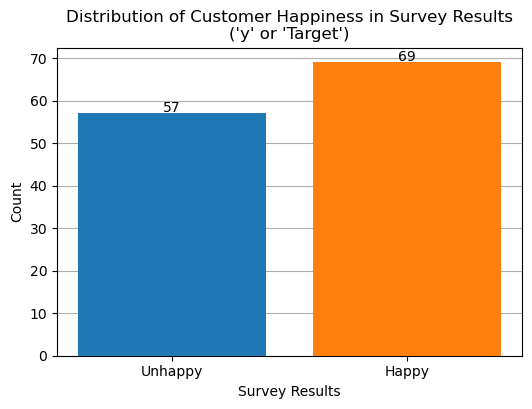

In [404]:
# create DataFrame with the specified order
data={'category':['Unhappy',
                  'Happy'],
        'y_value':[df['y'].value_counts()[0],
                   df['y'].value_counts()[1]]}
df_fig1=pd.DataFrame(data)

# set seaborn color palette - we like the generic colors
colors=sns.color_palette()

# define specific colors for 'Unhappy' and 'Happy'
# based on seaborn's color palette
color_map={'Unhappy':colors[0],
           'Happy':colors[1]}

# create the bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(x=df_fig1['category'],
               height=df_fig1['y_value'],
               color=[color_map[cat] for cat in df_fig1['category']],
               zorder=3)

# add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             yval + 0.4,
             int(yval),
             ha='center',
             zorder=4)

# add title and labels
plt.title("Distribution of Customer Happiness in Survey Results\n('y' or 'Target')")
plt.xlabel('Survey Results')
plt.ylabel('Count')

# show grid and plot
plt.gca().yaxis.grid(True, zorder=1)

# save and show plot
plt.savefig('../figs/1_ydistribution.pdf')
plt.savefig('../figs/1_ydistribution.png')
plt.show()

In [405]:
print(f"In the dataset, {round(df['y'].value_counts()[1]/df['y'].shape[0]*100,2)}% of respondents were happy,\nwhile {round(df['y'].value_counts()[0]/df['y'].shape[0]*100,0)}% of respondents were unhappy.")

In the dataset, 54.76% of respondents were happy,
while 45.0% of respondents were unhappy.


We can confidently say that there is a good _opportunity_ for the company to improve their product, as we see that just under 55% of their respondents were happy with their service. This number will become important later in the notebook as we work on training a model to improve the company's understanding of customer happiness.

### Figure 2: Distribution of survey results <a name='fig2'></a>

In [406]:
# prepare X data for plotting
col_list=[]

for i in df.columns:
    col_list.append(i)
    
col_list.remove('y')

df_melted=df.melt(value_vars=col_list,var_name='Variable',value_name='Value')

# calculate mean value per variable
mean_values=df_melted.groupby('Variable')['Value'].mean().to_dict()

In [407]:
mean_values

{'a_time': 4.333333333333333,
 'b_contents': 2.5317460317460316,
 'c_complete': 3.3095238095238093,
 'd_price': 3.746031746031746,
 'e_courier': 3.6507936507936507,
 'f_app': 4.253968253968254}

In [408]:
# create custom labels for following figure
labels=[f"{variable}: {mean_values[variable]:.2f}" for variable in mean_values.keys()]
labels

['a_time: 4.33',
 'b_contents: 2.53',
 'c_complete: 3.31',
 'd_price: 3.75',
 'e_courier: 3.65',
 'f_app: 4.25']

In [409]:
df_melted['Variable'].value_counts()

Variable
a_time        126
b_contents    126
c_complete    126
d_price       126
e_courier     126
f_app         126
Name: count, dtype: int64

In [410]:
xlabs=['Delivery Time',
       'Contents of Order',
       'Order Completeness',
       'Price for Order',
       'Satisfaction with Courier',
       'Satisfaction with App Experience']

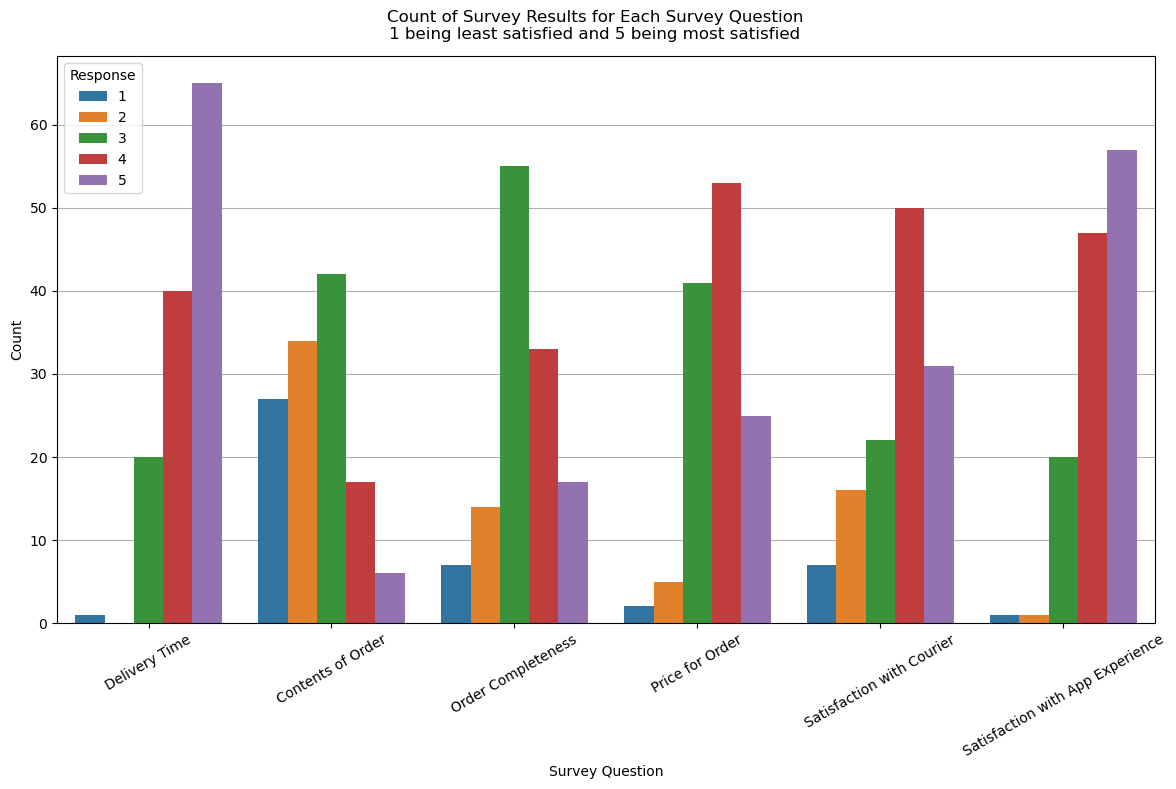

In [411]:
# plot distribution of survey results

plt.figure(figsize=(12,8))
ax=sns.countplot(data=df_melted,x='Variable',hue='Value')
plt.suptitle('Count of Survey Results for Each Survey Question\n1 being least satisfied and 5 being most satisfied')
plt.xlabel('Survey Question')
plt.ylabel('Count')
ax.set_axisbelow(True)
ax.yaxis.grid(True,which='major')
ax.set_xticklabels(xlabs)
plt.xticks(rotation=30)
plt.legend(title='Response',loc='upper left')
plt.tight_layout()
plt.savefig('../figs/1_xdistribution.pdf')
plt.savefig('../figs/1_xdistribution.png')
plt.show()

This plot illustrates well the distribution of responses received in the survey. Although it is harder to draw conclusions from this figure, I think it is still valid to understand the overall trends in the data. Figure 3 has more explanatory value.

### Figure 3: Mean response to survey question <a name='fig3'></a>

In [412]:
# setup labels for mean values
mean_values=df_melted.groupby('Variable')['Value'].mean()
mean_values=mean_values.round(decimals=2)
mean_values

Variable
a_time       4.33
b_contents   2.53
c_complete   3.31
d_price      3.75
e_courier    3.65
f_app        4.25
Name: Value, dtype: float64

In [413]:
# data labels
x=list(np.arange(6))
y=mean_values.iloc[:6].tolist()

print("x:")
print(x)
print("y:")
print(y)

x:
[0, 1, 2, 3, 4, 5]
y:
[4.33, 2.53, 3.31, 3.75, 3.65, 4.25]


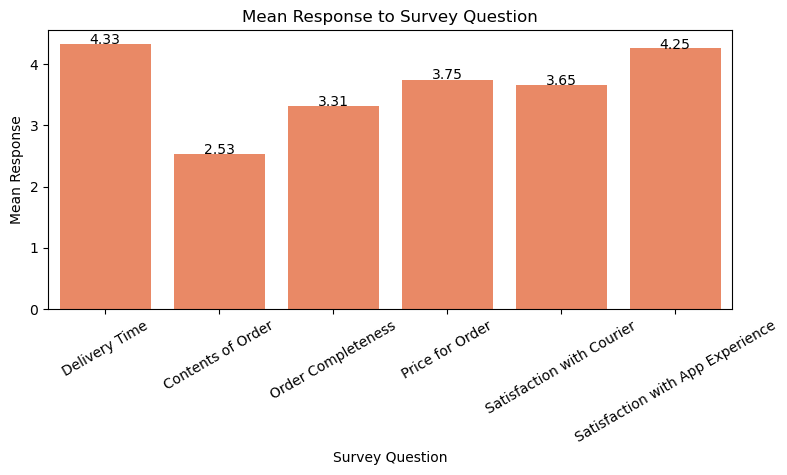

In [414]:
plt.figure(figsize=(10,6))
ax=sns.barplot(data=df_melted,x='Variable',y='Value',errorbar=None,color='coral')
plt.tight_layout(pad=10)
# plot labels
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center')
ax.set_xticklabels(xlabs,rotation=30)
ax.set_title('Mean Response to Survey Question')
ax.set_ylabel('Mean Response')
ax.set_xlabel('Survey Question')
plt.savefig('../figs/1_xmeandistribution.pdf')
plt.savefig('../figs/1_xmeandistribution.png')
plt.show()

The delivery time and app experience had the highest mean satisfaction in the survey, with the contents having the lowest overall.

### Figure 4: Correlation matrix <a name='fig4'></a>

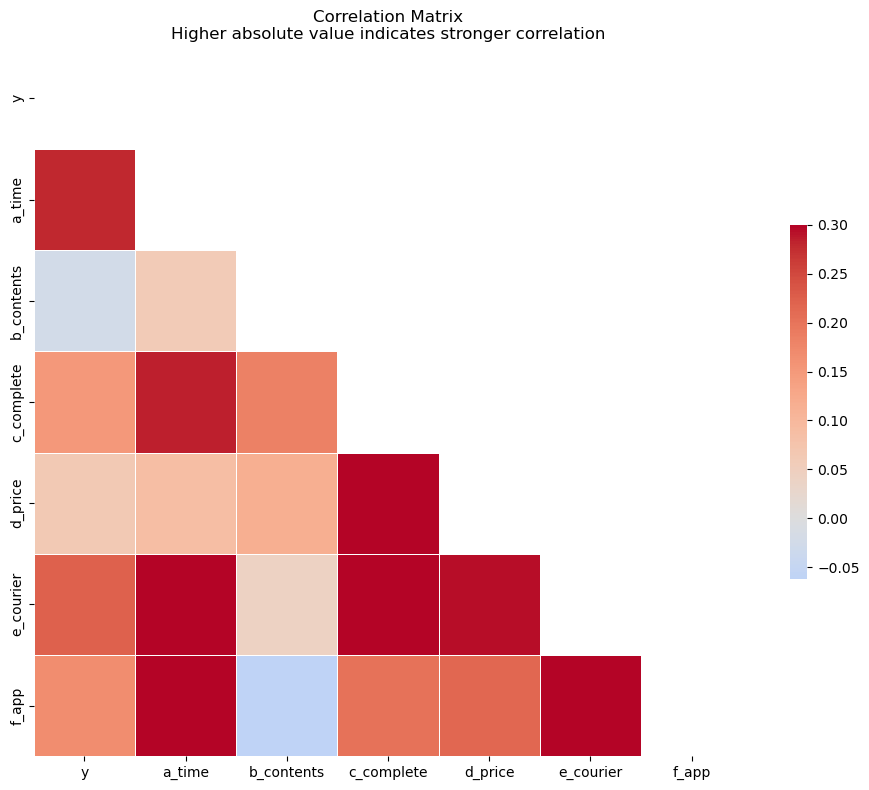

In [415]:
# compute correlation matrix
corr=df.corr()

# generate mask for the upper triangle
mask=np.triu(np.ones_like(corr, dtype=bool))

# set up matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='coolwarm',vmax=.3,center=0,
            square=True,linewidths=.5,annot=True,
            fmt='.2f',cbar_kws={"shrink":.5})
plt.title('Correlation Matrix\nHigher absolute value indicates stronger correlation')
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix_alt.pdf')
plt.savefig('../figs/1_corrmatrix_alt.png')

The results of the correlation matrix show that if one aspect of the experience is positive, the customer will rate others positive as well. One interesting correlation to highlight is the courier and time are connected, which makes sense: the courier is the person that gives you your order, and if the courier is on time you probably will rate the courier highly too.

### EDA Summary <a name='eda_sum'></a>

In the dataset that we were given, roughly half of the respondents were unhappy. From a business standpoint, this is an opportunity to increase the amount of satisfied customers. Hence the existence of the survey, ostensibly to understand how the company can improve the satisfaction of their customers.

The results from the survey show that the delivery time and the app experience are places where the company is doing well. Areas for improvement are ensuring that the order is prepared correctly and customers being able to find what they need when they place an order.

We need to do more modeling to understand which survey questions are most important and which can be removed. We will do this in the subsequent sections below.

## Imports and helper functions <a name='imports'></a>

In [679]:
import json
from datetime import datetime
from pathlib import Path
import inspect

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve,auc,roc_auc_score

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

In [417]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    return random_state

In [418]:
def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):
    
    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.
    
    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame 
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''
    
    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'
    
    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

## `lazypredict` <a name='lazy_predict'></a>

[`lazypredict`](#https://lazypredict.readthedocs.io/en/latest/) is a very helpful package that can run through generic builds of a multitude of models in order to get a high-level understanding of the performance of these models on your particular dataset. It is a great place to start and saves a lot of time that would be spent manually exploring the accuracy of different models.

### Specify random seed <a name='rand'></a>

In [419]:
# define random seed
seed=rand_gen()
seed

1513

In [420]:
# save random seed to file to access it later in the notebook
with open('random_seed.txt','w') as file:
    file.write(str(seed))

# verify that the number got saved
with open('random_seed.txt','r') as file:
    saved_seed=int(file.read())
    print(saved_seed)
    seed=saved_seed

1513


In [421]:
# source:
# https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

# set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
# set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
# set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x17F998AC0

### Specify test_size <a name='test'></a>

We want to have the most performant model as possible. We will try a `test_size` of 10%, rather than the usual 20%, to get the model to train on more data and hopefully have a better performance.

In [422]:
test_size=0.10
test_size

0.1

In [423]:
# save random seed to file to access it later in the notebook
with open('test_size.txt','w') as file:
    file.write(str(test_size))
    
# verify that the number got saved
with open('test_size.txt','r') as file:
    opened_test_size=float(file.read())
    print(opened_test_size)
    test_size=opened_test_size

0.1


### Read in and setup dataset <a name='read'></a>

In [424]:
# read in and setup dataset
df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary

#### Thresholding the data <a name='threshold'></a>

We'll run the `LazyClassifier` on a thresholded version of the dataset to simplify things for the models. 

If a responded gave a score of 4 or 5 in a survey, we can safely conclude that they were satisfied with that component of the survey.

In [425]:
# define thresholding function:
# if the person scored a category as a 4 or 5,
# we give a value of 1. Otherwise, we give it a 0
threshold_func = lambda x: 1 if x >= 4 else 0

# apply the function to the dataframe
X_threshold = X.map(threshold_func)

In [426]:
# train/test split
X_train_threshold, \
X_test_threshold, \
y_train_threshold, \
y_test_threshold = train_test_split(X_threshold, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

In [427]:
print(f'''
Shapes of splits:
X_train: {X_train_threshold.shape}
X_test:  {X_test_threshold.shape}
y_train: {y_train_threshold.shape}
y_test:  {y_test_threshold.shape}
''')


Shapes of splits:
X_train: (113, 6)
X_test:  (13, 6)
y_train: (113,)
y_test:  (13,)



### `LazyClassifier` <a name='lazy'></a>

Instantiate `LazyClassifier`:

In [428]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     random_state=seed)

Run `LazyClassifier`:

In [429]:
models_threshold, predictions = clf.fit(X_train=X_train_threshold,
                              X_test=X_test_threshold,
                              y_train=y_train_threshold,
                              y_test=y_test_threshold)

100%|█████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 58.75it/s]

[LightGBM] [Info] Number of positive: 62, number of negative: 51
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.548673 -> initscore=0.195309
[LightGBM] [Info] Start training from score 0.195309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Save `models_threshold` object:

In [430]:
fileDaterSaver(location='../joblib/',
               filetype='csv',
               object_=models_threshold,
               extra='1_lazypredict_modelsthreshold')

current_datetime: 2024-07-07 16:51:25.149950
../joblib/1_lazypredict_modelsthreshold_2024-07-07_16-51-25.csv
Successfully saved object_ to ../joblib/1_lazypredict_modelsthreshold_2024-07-07_16-51-25.csv


View results:

In [431]:
models_threshold

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.77,0.79,0.79,0.76,0.00
NearestCentroid,0.77,0.79,0.79,0.76,0.01
QuadraticDiscriminantAnalysis,0.77,0.77,0.77,0.77,0.00
GaussianNB,0.77,0.77,0.77,0.77,0.01
AdaBoostClassifier,0.69,0.70,0.70,0.69,0.03
LinearDiscriminantAnalysis,0.69,0.70,0.70,0.69,0.01
XGBClassifier,0.69,0.70,0.70,0.69,0.08
RidgeClassifierCV,0.69,0.70,0.70,0.69,0.01
RidgeClassifier,0.69,0.70,0.70,0.69,0.01


There are a number of higher-performing algorithms that show up with different seeds. These include `XGBoost`, `LGBMClassifier`, and other algorithms.

### Sidenote: Correlation Matrix on `get_dummies` data <a name='side_ohe'></a>

What are the correlations for a OneHotEncoded version of the data? Let's find out.

In [432]:
X.dtypes

a_time        int64
b_contents    int64
c_complete    int64
d_price       int64
e_courier     int64
f_app         int64
dtype: object

In [433]:
# `pd.get_dummies` requires the data be categorical:
X_cat=X.copy()

for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype('category')
    
X_cat.dtypes

a_time        category
b_contents    category
c_complete    category
d_price       category
e_courier     category
f_app         category
dtype: object

In [434]:
# make dummy version of dataset
X_ohe=pd.get_dummies(data=X_cat,
                     prefix=list(X_cat.columns),
                     drop_first=False) # I want to 
                                       # see all survey responses
                                       # that are in dataset

# train/test split
X_train_ohe, \
X_test_ohe, \
y_train_ohe, \
y_test_ohe = train_test_split(X_ohe, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

# check to make sure it worked
print(f'''
Shapes of splits:
X_train: {X_train_ohe.shape}
X_test:  {X_test_ohe.shape}
y_train: {y_train_ohe.shape}
y_test:  {y_test_ohe.shape}
''')
X_train_ohe.head(3)


Shapes of splits:
X_train: (113, 29)
X_test:  (13, 29)
y_train: (113,)
y_test:  (13,)



,a_time_1,a_time_3,a_time_4,a_time_5,b_contents_1,b_contents_2,b_contents_3,b_contents_4,b_contents_5,c_complete_1,...,e_courier_1,e_courier_2,e_courier_3,e_courier_4,e_courier_5,f_app_1,f_app_2,f_app_3,f_app_4,f_app_5
51,False,False,False,True,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
12,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
100,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True


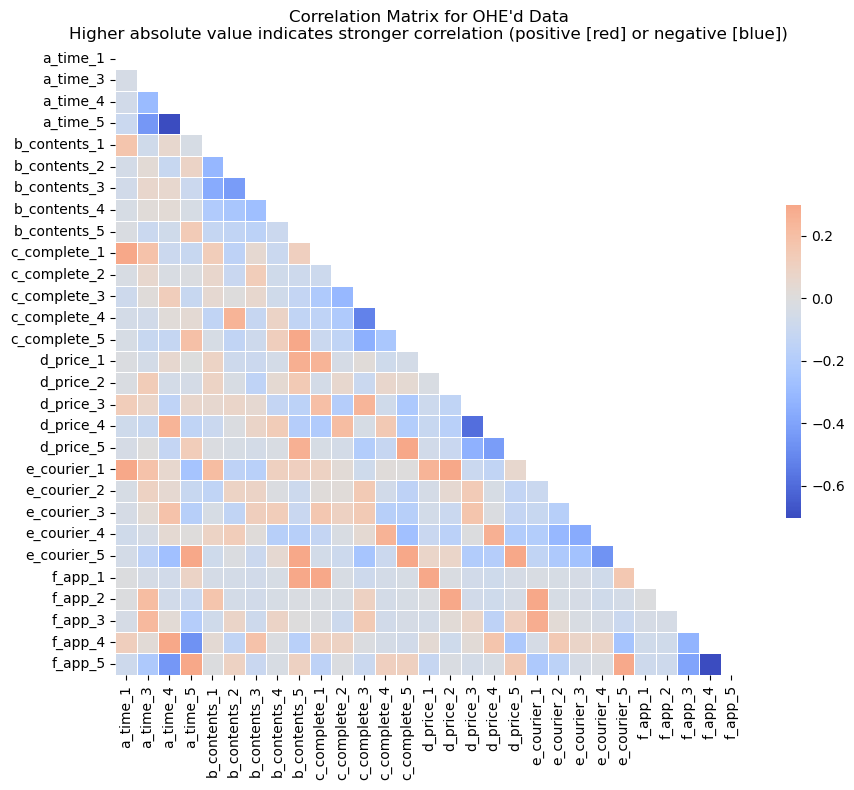

In [435]:
from matplotlib import pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr = X_ohe.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5},
            annot_kws={"size":5})
plt.title("Correlation Matrix for OHE'd Data\nHigher absolute value indicates stronger correlation (positive [red] or negative [blue])")
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix_ohe.pdf')
plt.savefig('../figs/1_corrmatrix_ohe.png')

Nothing much to learn here except that if a specific category scored high, other categories likely scored high. This is also true if categories scored low. Some categories are missing as there is no data recorded for them. For example, no respondent scored `time` as a `2`.

I'm curious why, for example, people that scored the `app` as `4` were not likely to score the `time` as `5`. This may be explained later in our modeling and statistical analysis.

## Modeling <a name='modeling'></a>

### Sidenote: Exploring different training sizes <a name='side_rand'></a>

Let's take a brief tangent to explore randomness and accuracy. I'm curious how the accuracy of a simple ML model increases or decreases based on the train/test split fraction and randomness seed. Running the `LazyClassifier` above with different seeds shows that randomness also plays a large role in this specific dataset. Let's look at the figures below.

In [436]:
# setup seeds for extra variability
seeds = [rand_gen() for i in range(10)]

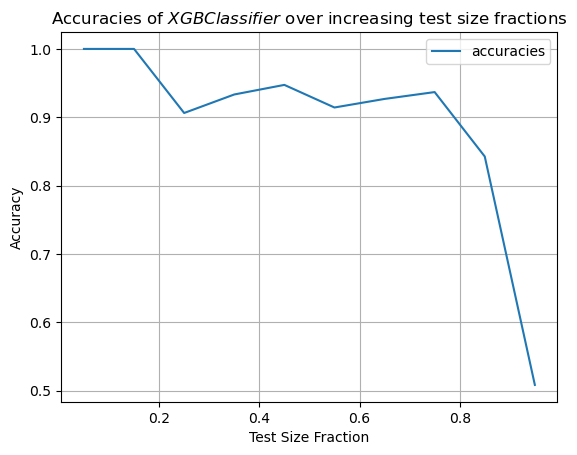

In [437]:
# setup size fraction for train_test_split
size_range=np.arange(0.5,10.5)
size_range=size_range*.1
    
# generate dataset
X_dummy, y_dummy = make_classification(n_samples=126,   # Number of samples
                           n_features=6,    # Number of features
                           n_informative=3, # Number of informative features
                           n_classes=2,      # Number of classes
                           random_state=42)  # Seed for reproducibility
    
# setup train/test split dictionaries
X_trains={}
X_tests={}
y_trains={}
y_tests={}

for test_size in size_range:
    X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_dummy, y_dummy, test_size=test_size, stratify=y_dummy, random_state=seed)
    
    # use test size as the key for each split
    X_trains[test_size] = X_dummy_train
    X_tests[test_size] = X_dummy_test
    y_trains[test_size] = y_dummy_train
    y_tests[test_size] = y_dummy_test
    
# setup accuracy list
accs=[]

for test_size in size_range:

#   instantiate
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    # train
    model.fit(X_trains[test_size], y_trains[test_size])

    # evaluate
    y_pred = model.predict(X_tests[test_size])  # Predict the test set
    accuracy = accuracy_score(y_tests[test_size], y_pred)  # Compute the accuracy
    
    accs.append(accuracy)

# plot accuracies
fig,ax=plt.subplots()
ax.plot(size_range,accs,label='accuracies')
ax.set_title('Accuracies of $XGBClassifier$ over increasing test size fractions')
ax.set_xlabel('Test Size Fraction')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()

plt.show()

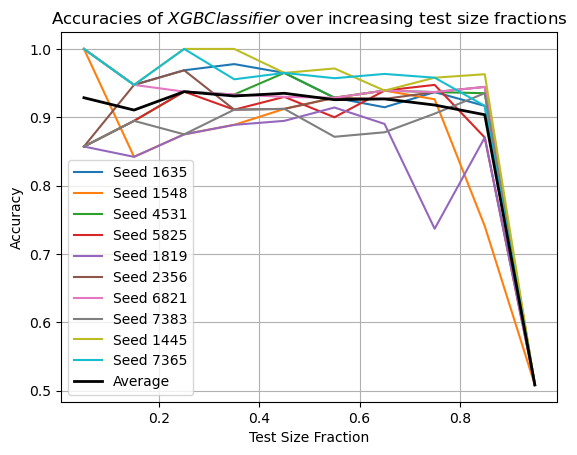

In [438]:
# Setup size fraction for train_test_split
size_range=np.arange(0.5,10.5)
size_range=size_range*.1

# Generate dataset
X_dummy, y_dummy = make_classification(n_samples=126,   # Number of samples
                                       n_features=6,    # Number of features
                                       n_informative=3,  # Number of informative features
                                       n_classes=2,      # Number of classes
                                       random_state=42)  # Seed for reproducibility

# Setup dictionaries to store results
accuracies = {seed: [] for seed in seeds}

# Loop over seeds
for seed in seeds:
    for test_size in size_range:
        # Perform train/test split
        X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_dummy, y_dummy, test_size=test_size, stratify=y_dummy, random_state=seed)
        
        # Instantiate model
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        
        # Train model
        model.fit(X_dummy_train, y_dummy_train)
        
        # Evaluate model
        y_pred = model.predict(X_dummy_test)
        accuracy = accuracy_score(y_dummy_test, y_pred)
        
        # Store accuracy
        accuracies[seed].append(accuracy)

# Calculate average accuracy for each test size fraction
mean_accuracies = np.mean([accuracies[seed] for seed in seeds], axis=0)
        
# Plot accuracies
fig, ax = plt.subplots()

for seed in seeds:
    ax.plot(size_range, accuracies[seed], label=f'Seed {seed}')

# Plot average accuracy with thicker line
ax.plot(size_range, mean_accuracies, label='Average', color='black', linewidth=2)

ax.set_title('Accuracies of $XGBClassifier$ over increasing test size fractions')
ax.set_xlabel('Test Size Fraction')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()

plt.show()

#### Now with our actual dataset

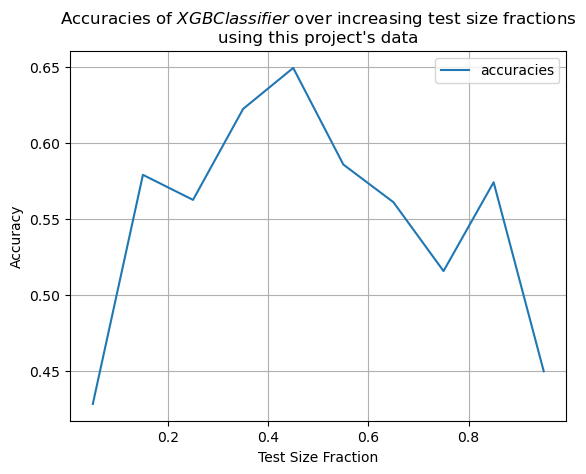

In [439]:
# setup size fraction for train_test_split
size_range=np.arange(0.5,10.5)
size_range=size_range*.1
        
# setup train/test split dictionaries
X_trains={}
X_tests={}
y_trains={}
y_tests={}

for test_size in size_range:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
    
    # use test size as the key for each split
    X_trains[test_size] = X_train
    X_tests[test_size] = X_test
    y_trains[test_size] = y_train
    y_tests[test_size] = y_test
    
# setup accuracy list
accs=[]

for test_size in size_range:

#   instantiate
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    # train
    model.fit(X_trains[test_size], y_trains[test_size])

    # evaluate
    y_pred = model.predict(X_tests[test_size])  # Predict the test set
    accuracy = accuracy_score(y_tests[test_size], y_pred)  # Compute the accuracy
    
    accs.append(accuracy)

# plot accuracies

fig,ax=plt.subplots()
ax.plot(size_range,accs,label='accuracies')
ax.set_title("Accuracies of $XGBClassifier$ over increasing test size fractions\nusing this project's data")
ax.set_xlabel('Test Size Fraction')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()

plt.show()

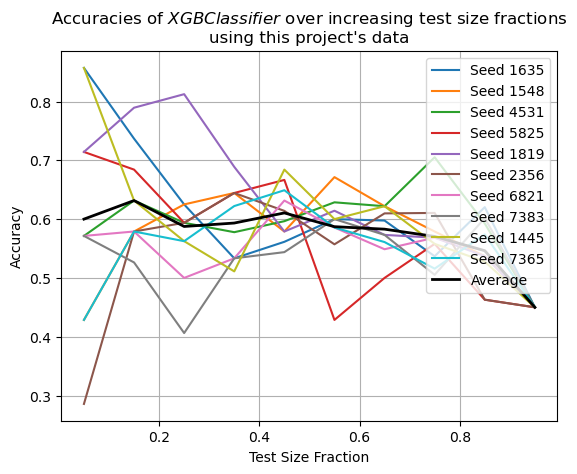

In [440]:
# Setup size fraction for train_test_split
size_range=np.arange(0.5,10.5)
size_range=size_range*.1

# Setup dictionaries to store results
accuracies = {seed: [] for seed in seeds}

# Loop over seeds
for seed in seeds:
    for test_size in size_range:
        # Perform train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
        
        # Instantiate model
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        
        # Train model
        model.fit(X_train, y_train)
        
        # Evaluate model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store accuracy
        accuracies[seed].append(accuracy)

# Calculate average accuracy for each test size fraction
mean_accuracies = np.mean([accuracies[seed] for seed in seeds], axis=0)
        
# Plot accuracies
fig, ax = plt.subplots()

for seed in seeds:
    ax.plot(size_range, accuracies[seed], label=f'Seed {seed}')

# Plot average accuracy with thicker line
ax.plot(size_range, mean_accuracies, label='Average', color='black', linewidth=2)

ax.set_title("Accuracies of $XGBClassifier$ over increasing test size fractions\nusing this project's data")
ax.set_xlabel('Test Size Fraction')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()

plt.show()

As we see here, randomness and test size plays a large role in determining the final accuracy, especially with a small dataset like ours.

In a previous seed iteration, a previous `random_seed`, it had given me the second-highest accuracy. You'll note that XGBoost is now at a different rank in the model options. This is a lesson that I must always specify a `random_state` to ensure reproducibility.

#### Regenerate working train/test splits for modeling

In [441]:
# access test size and seed

with open('random_seed.txt','r') as file:
    saved_seed=int(file.read())
    print('seed:',saved_seed)
    seed=saved_seed
    
with open('test_size.txt','r') as file:
    saved_test_size=file.read()
    print('test_size:',saved_test_size)
    test_size=float(saved_test_size)

seed: 1513
test_size: 0.1


In [442]:
# read in and setup dataset

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary

# define thresholding function
# if the person scored a category as a 4 or 5,
# we give a value of 1. Otherwise, we give it a 0
threshold_func = lambda x: 1 if x >= 4 else 0

# apply the function to the dataframe
X_threshold = X.map(threshold_func)

# train/test split
X_train_threshold, \
X_test_threshold, \
y_train_threshold, \
y_test_threshold = train_test_split(X_threshold, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

Create OHE version of the dataset:

In [443]:
X_cat=X.copy()

for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype('category')
    
X_cat.dtypes

X_ohe=pd.get_dummies(data=X_cat,
                     prefix=list(X_cat.columns),
                     drop_first=False) # I want to 
                                       # see all survey responses
                                       # that are in dataset
        
# train/test split
X_train_ohe, \
X_test_ohe, \
y_train_ohe, \
y_test_ohe = train_test_split(X_ohe, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

Create a regular, non-engineered version of the dataset:

In [444]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split(X, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

We will now run through a suite of off-the-shelf ML algorithms in the hopes that one (more more!) prove to be good candidates to run it through a hyperparameter tuning gauntlet.

### `XGBClassifier` <a name='xgb'></a>

#### Thresholded Data <a name='xgb_t'></a>

In [477]:
xgbc = XGBClassifier(random_state=seed)
print(model)
xgbc.fit(X_train_threshold, y_train_threshold)
print("fitting model")
y_pred = xgbc.predict(X_test_threshold)
print(y_pred)
print(f'Thresholded data\nScore on test: {xgbc.score(X_test_threshold,y_test_threshold)*100: .2f}%')
print(classification_report(y_test_threshold, y_pred))

DecisionTreeClassifier(random_state=1513)
fitting model
[1 0 0 0 0 1 1 0 0 1 0 0 1]
Thresholded data
Score on test:  69.23%
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.80      0.57      0.67         7

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13



#### Regular Data <a name='xgb_r'></a>

In [478]:
xgbc = XGBClassifier(random_state=seed)
print(model)
xgbc.fit(X_train, y_train)
print("fitting model")
y_pred = xgbc.predict(X_test)
print(y_pred)
print(f'Regular data\nScore on test: {xgbc.score(X_test,y_test)*100:.2f}%')
print(classification_report(y_test, y_pred))

DecisionTreeClassifier(random_state=1513)
fitting model
[1 0 0 0 0 1 1 0 0 1 1 0 1]
Regular data
Score on test: 61.54%
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.67      0.57      0.62         7

    accuracy                           0.62        13
   macro avg       0.62      0.62      0.62        13
weighted avg       0.62      0.62      0.62        13



#### OHE'd Data <a name='xgb_o'></a>

In [479]:
xgbc = XGBClassifier(random_state=seed)
print(model)
xgbc.fit(X_train_ohe, y_train_ohe)
print("fitting model")
y_pred = xgbc.predict(X_test_ohe)
print(y_pred)
print(f'OHE data\nScore on test: {xgbc.score(X_test_ohe,y_test_ohe)*100:.2f}%')
print(classification_report(y_test_ohe, y_pred))

DecisionTreeClassifier(random_state=1513)
fitting model
[1 0 0 0 0 1 1 0 0 1 0 0 1]
OHE data
Score on test: 69.23%
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.80      0.57      0.67         7

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13



Although with a seed of 411 the `XGBoost` model is showing great results, in the mid .70's, the low level of observations makes me uneasy about ending our modeling efforts here. Indeed, seed 6844 shows the typically poor accuracy in the low 0.60's. Let's keep exploring and see if other models show similar stability.

### `LGBMClassifier` <a name='lgb'></a>

Per the past results from the `lazypredict` [here](#lazy_predict_results), I will switch to the `LGBMClassifier`.

#### Thresholded data <a name='lgb_t'></a>

In [480]:
model=lgb.LGBMClassifier(random_state=seed,verbose=-1)
print(model)
model.fit(X_train_threshold,y_train_threshold)
print("fitting model")
y_pred=model.predict(X_test_threshold)
print(y_pred)
print(f'Accuracy: {accuracy_score(y_test_threshold,y_pred)*100:.2f}%')
print(classification_report(y_test_threshold,y_pred))

LGBMClassifier(random_state=1513, verbose=-1)
fitting model
[1 0 0 1 0 1 1 0 0 1 1 1 1]
Accuracy: 46.15%
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.50      0.57      0.53         7

    accuracy                           0.46        13
   macro avg       0.45      0.45      0.45        13
weighted avg       0.45      0.46      0.46        13



#### Regular data <a name='lgb_r'></a>

In [481]:
model=lgb.LGBMClassifier(random_state=seed,verbose=-1)
print(model)
model.fit(X_train,y_train)
print("fitting model")
y_pred=model.predict(X_test)
print(y_pred)
print(f'Regular data\nAccuracy: {accuracy_score(y_test,y_pred)*100:.2f}%')
print(classification_report(y_test,y_pred))

LGBMClassifier(random_state=1513, verbose=-1)
fitting model
[1 0 0 0 0 1 1 0 0 0 0 1 1]
Regular data
Accuracy: 53.85%
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.60      0.43      0.50         7

    accuracy                           0.54        13
   macro avg       0.55      0.55      0.54        13
weighted avg       0.55      0.54      0.53        13



#### OHE'd data <a name='lgb_o'></a>

In [482]:
model=lgb.LGBMClassifier(random_state=seed,verbose=-1)
print(model)
model.fit(X_train_ohe,y_train_ohe)
print("fitting model")
y_pred=model.predict(X_test_ohe)
print(y_pred)
print(f'OHE\nAccuracy: {accuracy_score(y_test_ohe,y_pred)*100:.2f}%')
print(classification_report(y_test_ohe,y_pred))

LGBMClassifier(random_state=1513, verbose=-1)
fitting model
[1 0 1 0 0 1 1 0 0 1 0 1 1]
OHE
Accuracy: 53.85%
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.57      0.57      0.57         7

    accuracy                           0.54        13
   macro avg       0.54      0.54      0.54        13
weighted avg       0.54      0.54      0.54        13



##### Would `drop_first=True` help at all? <a name='lgb_d'></a>

In [483]:
X_ohe_drop1=pd.get_dummies(data=X_cat,
                     prefix=list(X_cat.columns),
                     drop_first=True) # What if we drop_first?

In [484]:
# train/test split on drop first data
X_train_ohe_drop1, \
X_test_ohe_drop1, \
y_train_ohe_drop1, \
y_test_ohe_drop1 = train_test_split(X_ohe_drop1, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

In [485]:
# confirm that the split occurred
print(f'''
Shapes of splits:
X_train: {X_train_ohe_drop1.shape}
X_test:  {X_test_ohe_drop1.shape}
y_train: {y_train_ohe_drop1.shape}
y_test:  {y_test_ohe_drop1.shape}
''')


Shapes of splits:
X_train: (113, 23)
X_test:  (13, 23)
y_train: (113,)
y_test:  (13,)



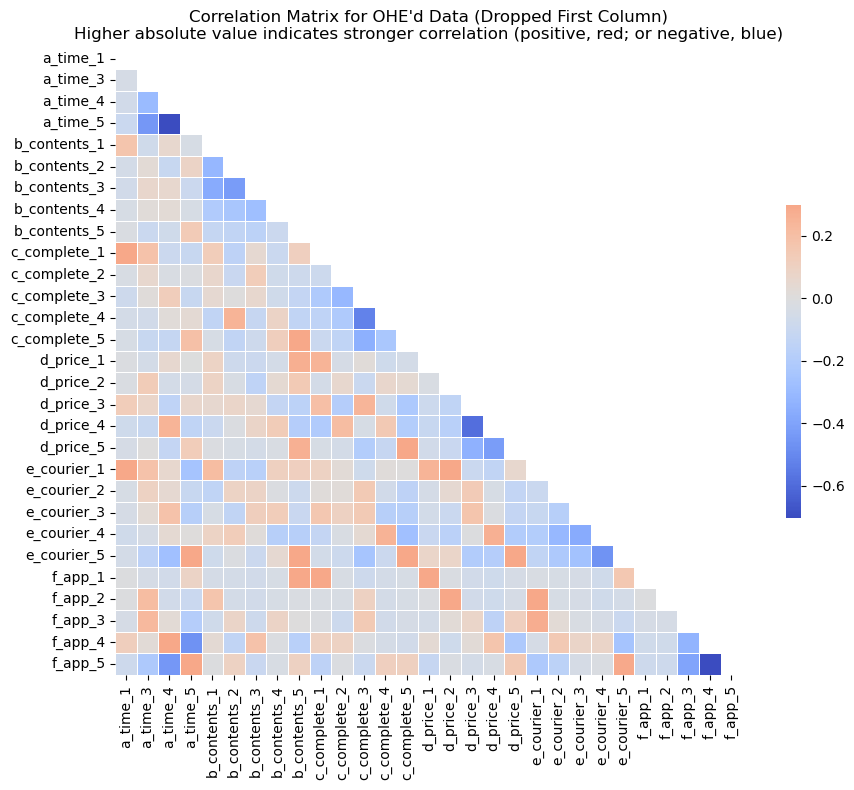

In [495]:
# Compute the correlation matrix
corr = X_ohe.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5},
            annot_kws={"size":5})
plt.title("Correlation Matrix for OHE'd Data (Dropped First Column)\nHigher absolute value indicates stronger correlation (positive, red; or negative, blue)")
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix_ohe_dropfirst.pdf')
plt.savefig('../figs/1_corrmatrix_ohe_dropfirst.png')

In [487]:
model=lgb.LGBMClassifier(random_state=seed,verbose=-1)
print(model)
model.fit(X_train_ohe_drop1,y_train_ohe_drop1)
print("fitting model")
y_pred=model.predict(X_test_ohe_drop1)
print(y_pred)
print(f'OHE (drop_first=True)\nAccuracy: {accuracy_score(y_test_ohe_drop1,y_pred)*100:.2f}%')
print(classification_report(y_test_ohe_drop1,y_pred))

LGBMClassifier(random_state=1513, verbose=-1)
fitting model
[1 0 1 0 0 1 1 0 0 1 0 1 1]
OHE (drop_first=True)
Accuracy: 53.85%
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.57      0.57      0.57         7

    accuracy                           0.54        13
   macro avg       0.54      0.54      0.54        13
weighted avg       0.54      0.54      0.54        13



There is no difference between the `drop_first` being `True` or `False`.

We will not continue with comparing results derived from the thresholded data to those from regular or OHE'd data, and instead just proceed with thresholded data.

### `DecisionTreeClassifier` <a name='dtc'></a>

#### Thresholded data <a name='dtc_t'></a>

In [488]:
model=DecisionTreeClassifier(random_state=seed)
print(model)
model.fit(X_train_threshold,y_train_threshold)
print("fitting model")
y_pred=model.predict(X_test_threshold)
print(y_pred)
print(f'Threshold\nAccuracy: {accuracy_score(y_test_threshold,y_pred)*100:.2f}%')
print(classification_report(y_test_threshold,y_pred))

DecisionTreeClassifier(random_state=1513)
fitting model
[1 0 0 0 0 1 1 0 0 1 0 1 1]
Threshold
Accuracy: 61.54%
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.67      0.57      0.62         7

    accuracy                           0.62        13
   macro avg       0.62      0.62      0.62        13
weighted avg       0.62      0.62      0.62        13



### `QuadraticDiscriminantAnalysis` <a name='qda'></a>

#### Thresholded data <a name='qda_t'></a>

In [624]:
model=QuadraticDiscriminantAnalysis()
print(model)
model.fit(X_train_threshold,y_train_threshold)
print("fitting model")
y_pred=model.predict(X_test_threshold)
print(y_pred)
print(f'Accuracy: {accuracy_score(y_test_threshold,y_pred)*100:.2f}%')
print(classification_report(y_test_threshold,y_pred))

QuadraticDiscriminantAnalysis()
fitting model
[1 0 0 0 0 1 1 1 0 1 0 0 1]
Accuracy: 76.92%
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.83      0.71      0.77         7

    accuracy                           0.77        13
   macro avg       0.77      0.77      0.77        13
weighted avg       0.78      0.77      0.77        13



### `Hyperopt` <a name='hyp'></a>

`Hyperopt` is a hyperparameter optimization package that is superior to `Scikit-Learn`'s `GridSearchCV` tool, in both speed and results. We will use it to explore the hyperparameter space of various algorithms to try and boost the performance of each model.

Tutorials are [here](#http://hyperopt.github.io/hyperopt/tutorials/01.BasicTutorial/) and [here](#https://towardsdev.com/optimizing-hyperparameters-with-hyperopt-a-hands-on-tutorial-2839efcbc177?gi=de88b6cfe1cd).  
And I'm following examples from [here](#https://github.com/hyperopt/hyperopt-sklearn) and [here](#https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce).

#### Run `Hyperopt` with `RFE` and `ExtraTreesClassifier` <a name='hyp_etc'></a>

Notes on `hyperopt` parameters:

* Using `RFE` to select which features are most important
* `ExtraTreesClassifier` is used as the final model as it gave good results from the `LazyPredict`

In [511]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0

    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type
        if t == 'extratrees':
            clf = ExtraTreesClassifier(**params)
        else:
            return 0
        
        # define RFE with the classifier
        rfe = RFE(estimator=clf, 
                  n_features_to_select=n_features_to_select)
        
        # perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f'new best: {acc} using {params['type']} at step {self.count}')
            self.best = acc
        if self.count % 50 == 0:
            print(f'iters: {self.count}, acc: {acc} using {params}')
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'extratrees',
        'n_features_to_select': hp.choice('n_features_to_select', 
                                          range(1, X.shape[1]+1)),
        'n_estimators': hp.choice('n_estimators', range(10, 100)),
        'max_depth': hp.choice('max_depth', range(1, 25)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'random_state': seed
    }
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X_threshold, y)

# initialize trials object
trials = Trials()

rstate = np.random.default_rng(seed)

# run optimization
best_extratrees = fmin(optimizer.objective, 
            space, 
            algo=tpe.suggest, 
            max_evals=500, 
            trials=trials,
            rstate=rstate,
            return_argmin=False)
print('best:')
print(best_extratrees)

new best: 0.532 using extratrees at step 1                                                    
new best: 0.5556923076923076 using extratrees at step 6                                       
new best: 0.5723076923076923 using extratrees at step 8                                       
new best: 0.5876923076923076 using extratrees at step 37                                      
iters: 50, acc: 0.49969230769230766 using {'criterion': 'gini', 'max_depth': 17, 'n_estimators': 21, 'n_features_to_select': 5, 'random_state': 1513, 'type': 'extratrees'}
new best: 0.6116923076923076 using extratrees at step 72                                      
iters: 100, acc: 0.532 using {'criterion': 'gini', 'max_depth': 16, 'n_estimators': 34, 'n_features_to_select': 1, 'random_state': 1513, 'type': 'extratrees'}
iters: 150, acc: 0.5636923076923076 using {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 21, 'n_features_to_select': 6, 'random_state': 1513, 'type': 'extratrees'}
iters: 200, acc: 0.5556

In [512]:
# save best
fileDaterSaver(location='../joblib/',
               filetype='json',
               object_=best_extratrees,
               extra='1_hyperopt_extratrees')

current_datetime: 2024-07-08 11:34:53.047409
../joblib/1_hyperopt_extratrees_2024-07-08_11-34-53.json
Successfully saved object_ to ../joblib/1_hyperopt_extratrees_2024-07-08_11-34-53.json


In [513]:
file_name='../joblib/1_hyperopt_extratrees_2024-07-08_11-34-53.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
# best_params

# extract best parameters
best_n_features_to_select = best_params['n_features_to_select']
del best_params['n_features_to_select']
best_type = best_params['type']
del best_params['type']
random_state=best_params['random_state']
random_state=int(random_state)
del best_params['random_state']

# train final model using best parameters
if best_type == 'extratrees':
    final_clf = ExtraTreesClassifier(**best_params)
    
# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 46.15%


This result is not great. Let's add more estimators but make them shallower in an effort to boost performance. We are also adding more code to tell us which features the best result selected.

In [508]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0
        self.best_features = None # adding best features

    def hyperopt_train_test(self, params):
        # extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type
        if t == 'extratrees':
            clf = ExtraTreesClassifier(**params)
        else:
            return 0
        
        # define RFE with the classifier
        rfe = RFE(estimator=clf, 
                  n_features_to_select=n_features_to_select)
        
        # fit RFE to get the selected features
        rfe.fit(self.X, self.y)
        
        # store selected features if current model is the best
        score = cross_val_score(rfe, self.X, self.y).mean()
        if score > self.best:
            self.best_features = rfe.support_
        
        return score

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f'new best: {acc} using {params["type"]} at step {self.count}')
            self.best = acc
        if self.count % 50 == 0:
            print(f'iters: {self.count}, acc: {acc} using {params}')
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'extratrees',
        'n_features_to_select': hp.choice('n_features_to_select', 
                                          range(1, X.shape[1]+1)),
        'n_estimators': hp.choice('n_estimators', range(10, 1000)),
        'max_depth': hp.choice('max_depth', range(1, 5)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'random_state': seed
    }
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X, y)

# initialize trials object
trials = Trials()

rstate = np.random.default_rng(seed)

# run optimization
best_extratrees = fmin(optimizer.objective, 
                       space, 
                       algo=tpe.suggest, 
                       max_evals=500, 
                       trials=trials,
                       rstate=rstate,
                       return_argmin=False)

print('best:')
print(best_extratrees)

# print selected features of the best model
selected_features = optimizer.best_features
print('Selected features:', selected_features)

new best: 0.6190769230769232 using extratrees at step 1                                       
new best: 0.6427692307692309 using extratrees at step 11                                      
iters: 50, acc: 0.5790769230769232 using {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 258, 'n_features_to_select': 1, 'random_state': 1513, 'type': 'extratrees'}
new best: 0.6587692307692307 using extratrees at step 79                                      
iters: 100, acc: 0.604 using {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 983, 'n_features_to_select': 3, 'random_state': 1513, 'type': 'extratrees'}
iters: 150, acc: 0.6427692307692309 using {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 416, 'n_features_to_select': 2, 'random_state': 1513, 'type': 'extratrees'}
iters: 200, acc: 0.6187692307692308 using {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 425, 'n_features_to_select': 2, 'random_state': 1513, 'type': 'extratrees'}
iters: 250, acc: 0.6427692307692309 using

In [509]:
# save best
fileDaterSaver(location='../joblib/',
               filetype='json',
               object_=best_extratrees,
               extra='1_hyperopt_extratrees')

current_datetime: 2024-07-08 11:29:05.222723
../joblib/1_hyperopt_extratrees_2024-07-08_11-29-05.json
Successfully saved object_ to ../joblib/1_hyperopt_extratrees_2024-07-08_11-29-05.json


In [498]:
best_extratrees

{'criterion': 'gini',
 'max_depth': 4,
 'n_estimators': 37,
 'n_features_to_select': 2,
 'random_state': 1513,
 'type': 'extratrees'}

##### Run the best parameters on the test set

In [510]:
# file_name='../joblib/1_hyperopt_extratrees_2024-06-26_12-00-22.json'
# file_name='../joblib/1_hyperopt_extratrees_2024-06-28_15-28-26.json'
# file_name='../joblib/1_hyperopt_extratrees_2024-07-08_10-39-36.json'
file_name='../joblib/1_hyperopt_extratrees_2024-07-08_11-29-05.json'


# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
# best_params

# extract best parameters
best_n_features_to_select = best_params['n_features_to_select']
del best_params['n_features_to_select']
best_type = best_params['type']
del best_params['type']
random_state=best_params['random_state']
random_state=int(random_state)
del best_params['random_state']

# train final model using best parameters
if best_type == 'extratrees':
    final_clf = ExtraTreesClassifier(**best_params)
    
# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 46.15%


This result is very poor, and below the base rate of about 55%. Let's try a different algorithm.

#### Run `Hyperopt` with `RFE` and `XGBoost` <a name='hyp_xgb'></a>

In [565]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0
        self.best_features = None

    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # Extract classifier type
        t = params['type']
        del params['type']
        
        # Define classifier based on type
        elif t == 'xgboost':
            clf = XGBClassifier(**params)
        else:
            return 0
        
        # Define RFE with the classifier
        rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select)
        
        # Fit RFE to get the selected features
        rfe.fit(self.X, self.y)
        
        # Store selected features if current model is the best
        score = cross_val_score(rfe, self.X, self.y).mean()
        if score > self.best:
            self.best_features = rfe.support_
        
        # Perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f'new best: {acc} using {params["type"]} at step {self.count}')
            self.best = acc
        if self.count % 50 == 0:
            print(f'iters: {self.count}, acc: {acc} using {params}')
        return {'loss': -acc, 'status': STATUS_OK}

# Define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'xgboost',
        'n_features_to_select': hp.choice('n_features_to_select', range(1, X.shape[1] + 1)),
        'n_estimators': hp.choice('n_estimators', range(10, 1000)),
        'max_depth': hp.choice('max_depth', range(1, 5)),
        'learning_rate': hp.choice('learning_rate', np.linspace(0.001,1,endpoint=False)),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'random_state': seed
    }
])

# Instantiate optimizer
optimizer = HyperoptOptimizer(X, y)

# Initialize trials object
trials = Trials()

rstate = np.random.default_rng(seed)

# Run optimization
best_xgb = fmin(
    optimizer.objective, 
    space, 
    algo=tpe.suggest, 
    max_evals=500, 
    trials=trials,
    rstate=rstate,
    return_argmin=False
)

print('best:')
print(best_xgb)

# Print selected features of the best model
selected_features = optimizer.best_features
print('Selected features:', selected_features)

new best: 0.6350769230769232 using xgboost at step 1                                          
new best: 0.6430769230769232 using xgboost at step 2                                          
new best: 0.6510769230769232 using xgboost at step 8                                          
new best: 0.6676923076923077 using xgboost at step 14                                         
iters: 50, acc: 0.6276923076923077 using {'colsample_bytree': 0.8919886818767253, 'learning_rate': 0.88012, 'max_depth': 4, 'n_estimators': 156, 'n_features_to_select': 4, 'random_state': 1513, 'subsample': 0.6061383828513944, 'type': 'xgboost'}
iters: 100, acc: 0.5864615384615385 using {'colsample_bytree': 0.6240730128849397, 'learning_rate': 0.06094000000000001, 'max_depth': 4, 'n_estimators': 964, 'n_features_to_select': 5, 'random_state': 1513, 'subsample': 0.5460990618036622, 'type': 'xgboost'}
iters: 150, acc: 0.6510769230769232 using {'colsample_bytree': 0.6699265788562201, 'learning_rate': 0.04096, 'max_d

In [566]:
# save best
fileDaterSaver(location='../joblib/',
               filetype='json',
               object_=best_xgb,
               extra='1_hyperopt_xgb')

current_datetime: 2024-07-08 17:04:50.373636
../joblib/1_hyperopt_xgb_2024-07-08_17-04-50.json
Successfully saved object_ to ../joblib/1_hyperopt_xgb_2024-07-08_17-04-50.json


##### Run the best parameters on the test set

In [569]:
# file_name='../joblib/1_hyperopt_randomforestclf_2024-06-26_12-03-14.json'
# file_name='../joblib/1_hyperopt_randomforestclf_2024-06-26_12-47-33.json'
# file_name='../joblib/1_hyperopt_randomforestclf_2024-07-08_13-17-28.json'
file_name='../joblib/1_hyperopt_xgb_2024-07-08_17-04-50.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
best_params

{'colsample_bytree': 0.9314556989120611,
 'learning_rate': 0.9800200000000001,
 'max_depth': 2,
 'n_estimators': 284,
 'n_features_to_select': 3,
 'random_state': 1513,
 'subsample': 0.8460262243091863,
 'type': 'xgboost'}

In [570]:
# extract best parameters
best_n_features_to_select = best_params['n_features_to_select']
del best_params['n_features_to_select']
best_type = best_params['type']
del best_params['type']
random_state=best_params['random_state']
random_state=int(random_state)
del best_params['random_state']

# train final model using best parameters
if best_type == 'xgb':
    final_clf = XGBClassifier(**best_params)
    
# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 61.54%


#### Run `Hyperopt` with `RFE` and `DecisionTreeClassifier` <a name='hyp_dtc'></a>

In [574]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0
        self.best_features = None

    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # Extract classifier type
        t = params['type']
        del params['type']
        
        # Define classifier based on type
        if t == 'decisiontree':
            clf = DecisionTreeClassifier(**params)
        else:
            return 0
        
        # Define RFE with the classifier
        rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select)
        
        # Fit RFE to get the selected features
        rfe.fit(self.X, self.y)
        
        # Store selected features if current model is the best
        score = cross_val_score(rfe, self.X, self.y).mean()
        if score > self.best:
            self.best_features = rfe.support_
        
        # Perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f'new best: {acc} using {params["type"]} at step {self.count}')
            self.best = acc
        if self.count % 250 == 0:
            print(f'iters: {self.count}, acc: {acc} using {params}')
        return {'loss': -acc, 'status': STATUS_OK}

# Define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'decisiontree',
        'n_features_to_select': hp.choice('n_features_to_select', range(1, X.shape[1] + 1)),
        'max_depth': hp.choice('max_depth', range(1, 5)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'splitter': hp.choice('splitter', ["best", "random"]),
        'random_state': seed
    }
])

# Instantiate optimizer
optimizer = HyperoptOptimizer(X, y)

# Initialize trials object
trials = Trials()

rstate = np.random.default_rng(seed)

# Run optimization
best_dtc = fmin(
    optimizer.objective, 
    space, 
    algo=tpe.suggest, 
    max_evals=1000, 
    trials=trials,
    rstate=rstate,
    return_argmin=False
)

print('best:')
print(best_dtc)

# Print selected features of the best model
selected_features = optimizer.best_features
print('Selected features:', selected_features)

new best: 0.6350769230769232 using decisiontree at step 1                                     
new best: 0.6584615384615385 using decisiontree at step 12                                    
iters: 250, acc: 0.5313846153846153 using {'criterion': 'gini', 'max_depth': 4, 'n_features_to_select': 6, 'random_state': 1513, 'splitter': 'random', 'type': 'decisiontree'}
iters: 500, acc: 0.6104615384615385 using {'criterion': 'entropy', 'max_depth': 1, 'n_features_to_select': 3, 'random_state': 1513, 'splitter': 'random', 'type': 'decisiontree'}
iters: 750, acc: 0.6350769230769232 using {'criterion': 'entropy', 'max_depth': 2, 'n_features_to_select': 6, 'random_state': 1513, 'splitter': 'best', 'type': 'decisiontree'}
iters: 1000, acc: 0.6584615384615385 using {'criterion': 'entropy', 'max_depth': 2, 'n_features_to_select': 6, 'random_state': 1513, 'splitter': 'random', 'type': 'decisiontree'}
100%|██████████████████| 1000/1000 [00:22<00:00, 44.80trial/s, best loss: -0.6584615384615385]
best:
{

In [575]:
# save best
fileDaterSaver(location='../joblib/',
               filetype='json',
               object_=best_dtc,
               extra='1_hyperopt_dtc')

current_datetime: 2024-07-08 17:22:26.120703
../joblib/1_hyperopt_dtc_2024-07-08_17-22-26.json
Successfully saved object_ to ../joblib/1_hyperopt_dtc_2024-07-08_17-22-26.json


##### Run the best parameters on the test set

In [582]:
file_name='../joblib/1_hyperopt_dtc_2024-07-08_17-22-26.json'

# extract best params file
with open(file_name,'r') as file:
    best_params_dtc=json.load(file)
    
best_params_dtc

{'criterion': 'entropy',
 'max_depth': 2,
 'n_features_to_select': 6,
 'random_state': 1513,
 'splitter': 'random',
 'type': 'decisiontree'}

In [584]:
# extract best parameters

# train final model using best parameters
if best_type == 'dtc':
    final_clf = DecisionTreeClassifier(**best_params_dtc)
    
# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 61.54%


#### Run `Hyperopt` with `RFE` and `RandomForestClassifier` <a name='hyp_rfc'></a>

In [514]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0
        self.best_features = None

    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type
        if t == 'randomforest':
            clf = RandomForestClassifier(**params)
        else:
            return 0
        
        # define RFE with the classifier
        rfe = RFE(estimator=clf, 
                  n_features_to_select=n_features_to_select)
        
        # fit RFE to get the selected features
        rfe.fit(self.X, self.y)
        
        # store selected features if current model is the best
        score = cross_val_score(rfe, self.X, self.y).mean()
        if score > self.best:
            self.best_features = rfe.support_
        
        # perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f'new best: {acc} using {params['type']} at step {self.count}')
            self.best = acc
        if self.count % 50 == 0:
            print(f'iters: {self.count}, acc: {acc} using {params}')
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'randomforest',
        'n_features_to_select': hp.choice('n_features_to_select', 
                                          range(1, X.shape[1]+1)),
        'n_estimators': hp.choice('n_estimators', range(10, 1000)),
        'max_depth': hp.choice('max_depth', range(1, 5)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'random_state': seed
    },
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X_threshold, y)

# initialize trials object
trials = Trials()

rstate = np.random.default_rng(seed)

# run optimization
best_randomforestclf = fmin(optimizer.objective, 
            space, 
            algo=tpe.suggest, 
            max_evals=500, 
            trials=trials,
            rstate=rstate,
            return_argmin=False)
print('best:')
print(best_randomforestclf)

# print selected features of the best model
selected_features = optimizer.best_features
print('Selected features:', selected_features)

new best: 0.532 using randomforest at step 1                                                  
new best: 0.5876923076923076 using randomforest at step 2                                     
new best: 0.6033846153846153 using randomforest at step 4                                     
iters: 50, acc: 0.532 using {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 237, 'n_features_to_select': 1, 'random_state': 1513, 'type': 'randomforest'}
iters: 100, acc: 0.5393846153846154 using {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 102, 'n_features_to_select': 5, 'random_state': 1513, 'type': 'randomforest'}
new best: 0.6436923076923077 using randomforest at step 124                                   
iters: 150, acc: 0.5553846153846154 using {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 386, 'n_features_to_select': 5, 'random_state': 1513, 'type': 'randomforest'}
iters: 200, acc: 0.532 using {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 407, 'n_features_to_select': 

In [515]:
# save best
fileDaterSaver(location='../joblib/',
               filetype='json',
               object_=best_randomforestclf,
               extra='1_hyperopt_randomforestclf')

current_datetime: 2024-07-08 13:17:28.936331
../joblib/1_hyperopt_randomforestclf_2024-07-08_13-17-28.json
Successfully saved object_ to ../joblib/1_hyperopt_randomforestclf_2024-07-08_13-17-28.json


##### Run the best parameters on the test set

In [519]:
# file_name='../joblib/1_hyperopt_randomforestclf_2024-06-26_12-03-14.json'
# file_name='../joblib/1_hyperopt_randomforestclf_2024-06-26_12-47-33.json'
file_name='../joblib/1_hyperopt_randomforestclf_2024-07-08_13-17-28.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
best_params

{'criterion': 'gini',
 'max_depth': 3,
 'n_estimators': 24,
 'n_features_to_select': 5,
 'random_state': 1513,
 'type': 'randomforest'}

In [520]:
# extract best parameters
best_n_features_to_select = best_params['n_features_to_select']
del best_params['n_features_to_select']
best_type = best_params['type']
del best_params['type']
random_state=best_params['random_state']
random_state=int(random_state)
del best_params['random_state']

# train final model using best parameters
if best_type == 'randomforest':
    final_clf = RandomForestClassifier(**best_params)
    
# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 46.15%


#### Run `Hyperopt` with `RFE` and `LGBMClassifier` <a name='hyp_lgb'></a>

Notes on `hyperopt` parameters

* Using `RFE` to select which features are most important
* `LGBMClassifier` is used as the final model as it also yielded good generic results from the `LazyPredict`
* It also seems to be better performant on smaller datasets, according to the work detailed [here](https://www.data-cowboys.com/blog/which-machine-learning-classifiers-are-best-for-small-datasets)

Run base model to compare with `hyperopt`:

In [521]:
model=LGBMClassifier(random_state=seed,verbose=-1)
print('model:',model)
model.fit(X_train_threshold,y_train_threshold)
print("fitting model")
y_pred=model.predict(X_test_threshold)
print('y_pred:',y_pred)
accuracy=accuracy_score(y_test_threshold,y_pred)
print(f'Accuracy: {accuracy:.2f}')

model: LGBMClassifier(random_state=1513, verbose=-1)
fitting model
y_pred: [1 0 0 1 0 1 1 0 0 1 1 1 1]
Accuracy: 0.46


This is the typical accuracy seen. Let's now turn to `hyperopt` to see if we can improve the accuracy.

In [522]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0
        self.best_features = None
        
    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type            
        if t == 'lgbm':
            clf = LGBMClassifier(**params)
        else:
            return 0
        
        # define RFE with the classifier
        rfe = RFE(estimator=clf, 
                  n_features_to_select=n_features_to_select)
        
        # fit RFE to get the selected features
        rfe.fit(self.X, self.y)
        
        # store selected features if current model is the best
        score = cross_val_score(rfe, self.X, self.y).mean()
        if score > self.best:
            self.best_features = rfe.support_
        
        # perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()
               
        # create LightGBM dataset with categorical features specified
        train_data = lgb.Dataset(self.X, label=self.y, categorical_feature=[0, 1, 2, 3, 4, 5])
        
    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f'new best: {acc} using {params['type']} at step {self.count}')
            self.best = acc
        if self.count % 250 == 0:
            print('iters:', self.count, ', acc:', acc, 'using', params)
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'lgbm',
        'min_data_in_bin': 1,
        'min_data_in_leaf': 1,
        'verbose': -1,
        'boosting_type': hp.choice('boosting_type',['gbdt','dart','rf']),
        'n_features_to_select': hp.choice('n_features_to_select', range(1, X_threshold.shape[1]+1)),
        'num_leaves': hp.choice('num_leaves', range(10, 500)),
        'learning_rate': hp.loguniform('learning_rate', -4, 0),
        'n_estimators': hp.choice('n_estimators', range(50, 1000)),
        'max_depth': hp.choice('max_depth', range(1, 5)),
        'min_child_samples': hp.choice('min_child_samples', range(5, 250)),
        'subsample': hp.uniform('subsample', 0.01, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
        'random_state': seed,
        'n_jobs': -1,
        'reg_alpha': hp.uniform('reg_alpha',0.001,100),
        'reg_lambda': hp.uniform('reg_lambda',0.001,100),
        'importance_type': hp.choice('importance_type',['split','gain'])
    }
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X_threshold, y)

# initialize trials object
trials = Trials()

# define random state
rstate = np.random.default_rng(seed)

# run optimization
best_lgbm = fmin(optimizer.objective, 
            space, 
            algo=tpe.suggest, 
            max_evals=500, 
            trials=trials,
            rstate=rstate,
            return_argmin=False)
print('best:')
print(best_lgbm)

# print selected features of the best model
selected_features = optimizer.best_features
print('Selected features:', selected_features)

new best: 0.5476923076923077 using lgbm at step 1                                             
new best: 0.5956923076923076 using lgbm at step 65                                            
new best: 0.6033846153846153 using lgbm at step 99                                            
new best: 0.6196923076923077 using lgbm at step 101                                           
iters:                                                                                        
250                                                                                           
, acc:                                                                                        
0.5476923076923077                                                                            
using                                                                                         
{'boosting_type': 'gbdt', 'colsample_bytree': 0.5996742110046456, 'importance_type': 'split', 'learning_rate': 0.9936942205785314, 'max_depth': 3

Save best parameters and run on test set

In [523]:
# save best
fileDaterSaver(location='../joblib/',
               filetype='json',
               object_=best_lgbm,
               extra='1_hyperopt_lgbm')

current_datetime: 2024-07-08 13:51:08.553946
../joblib/1_hyperopt_lgbm_2024-07-08_13-51-08.json
Successfully saved object_ to ../joblib/1_hyperopt_lgbm_2024-07-08_13-51-08.json


##### Run the best parameters on the test set

In [525]:
# file_name='../joblib/1_hyperopt_lgbm_2024-06-26_12-03-47.json'
file_name='../joblib/1_hyperopt_lgbm_2024-07-08_13-51-08.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
# extract best parameters
best_n_features_to_select = best_params['n_features_to_select']
del best_params['n_features_to_select']
best_type = best_params['type']
del best_params['type']
random_state=best_params['random_state']
random_state=int(random_state)
del best_params['random_state']

# # train final model using best parameters
if best_type == 'lgbm':
    final_clf = LGBMClassifier(**best_params)

# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 46.15%


Without RFE:

In [526]:
# file_name='../joblib/1_hyperopt_lgbm_2024-06-26_12-03-47.json'
file_name='../joblib/1_hyperopt_lgbm_2024-07-08_13-51-08.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)

if best_type == 'lgbm':
    final_clf = LGBMClassifier(**best_params)

# fit final model on entire training set
final_clf.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_clf.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 38.46%


#### Run `Hyperopt` with `LogisticRegression` using all types of solvers <a name='hyp_lr1'></a>

Let's take a step back and try `LogisticRegression`, but expand the search to include all types of solvers. We're trying to find a repeatedly accurate model.

In [590]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0
        
    def hyperopt_train_test(self, params):
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type            
        if t == 'lrx':
            clf = LogisticRegression(**params)
        else:
            return 0
        
        # perform cross-validation
        return cross_val_score(clf, self.X, self.y, cv=5).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f"new best: {acc} using {params['type']} at step {self.count}")
            self.best = acc
        if self.count % 250 == 0:
            print('iters:', self.count, ', acc:', acc, 'using', params)
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [

    {
        'type': 'lrx',
        'penalty': hp.choice('penalty_liblinear', ['l1', 'l2']),
        'tol': hp.loguniform('tol_liblinear', np.log(1e-7), np.log(1e-1)),
        'C': hp.loguniform('C_liblinear', np.log(1e-5), np.log(1e5)),
        'fit_intercept': hp.choice('fit_intercept_liblinear', [True, False]),
        'intercept_scaling': hp.uniform('intercept_scaling_liblinear', 0, 4),
        'solver': 'liblinear',
        'multi_class': hp.choice('multi_class_liblinear',['auto','ovr']),
        'max_iter': 10000,#hp.choice('max_iter_liblinear',[int(x) for x in np.logspace(1, 4, 10)]),
        'l1_ratio': hp.choice('l1_ratio_liblinear',np.logspace(-3,0,10)),
        'n_jobs': -1
    },
    {
        'type': 'lrx',
        'penalty': hp.choice('penalty_newton_cg', ['l2', None]),
        'tol': hp.loguniform('tol_newton_cg', np.log(1e-7), np.log(1e-1)),
        'C': hp.loguniform('C_newton_cg', np.log(1e-5), np.log(1e5)),
        'fit_intercept': hp.choice('fit_intercept_newton_cg', [True, False]),
        'intercept_scaling': hp.uniform('intercept_scaling_newton_cg', 0, 4),
        'solver': 'newton-cg',
        'multi_class': hp.choice('multi_class_newton_cg',['auto','ovr','multinomial']),
        'max_iter': 10000,#hp.choice('max_iter_newton_cg',[int(x) for x in np.logspace(1, 4, 10)]),
        'l1_ratio': hp.choice('l1_ratio_newton_cg',np.logspace(-3,0,10)),
        'n_jobs': -1
    },
    {
        'type': 'lrx',
        'penalty': hp.choice('penalty_newton_cholesky', ['l2', None]),
        'tol': hp.loguniform('tol_newton_cholesky', np.log(1e-7), np.log(1e-1)),
        'C': hp.loguniform('C_newton_cholesky', np.log(1e-5), np.log(1e5)),
        'fit_intercept': hp.choice('fit_intercept_newton_cholesky', [True, False]),
        'intercept_scaling': hp.uniform('intercept_scaling_newton_cholesky', 0, 4),
        'solver': 'newton-cholesky',
        'multi_class': hp.choice('multi_class_newton_cholesky',['auto','ovr']),
        'max_iter': 10000,#hp.choice('max_iter_newton_cholesky',[int(x) for x in np.logspace(1, 4, 10)]),
        'l1_ratio': hp.choice('l1_ratio_newton_cholesky',np.logspace(-3,0,10)),
        'n_jobs': -1
    },
    {
        'type': 'lrx',
        'penalty': hp.choice('penalty_sag', ['l2', None]),
        'tol': hp.loguniform('tol_sag', np.log(1e-7), np.log(1e-1)),
        'C': hp.loguniform('C_sag', np.log(1e-5), np.log(1e5)),
        'fit_intercept': hp.choice('fit_intercept_sag', [True, False]),
        'intercept_scaling': hp.uniform('intercept_scaling_sag', 0, 4),
        'solver': 'sag',
        'multi_class': hp.choice('multi_class_sag',['auto','ovr','multinomial']),
        'max_iter': 10000,#hp.choice('max_iter_sag',[int(x) for x in np.logspace(1, 4, 10)]),
        'l1_ratio': hp.choice('l1_ratio_sag',np.logspace(-3,0,10)),
        'n_jobs': -1
    },
    {
        'type': 'lrx',
        'penalty': hp.choice('penalty_saga', ['elasticnet', 'l1', 'l2', None]),
        'tol': hp.loguniform('tol_saga', np.log(1e-7), np.log(1e-1)),
        'C': hp.loguniform('C_saga', np.log(1e-5), np.log(1e5)),
        'fit_intercept': hp.choice('fit_intercept_saga', [True, False]),
        'intercept_scaling': hp.uniform('intercept_scaling_saga', 0, 4),
        'solver': 'saga',
        'multi_class': hp.choice('multi_class_saga',['auto','ovr','multinomial']),
        'max_iter': 10000,#hp.choice('max_iter_saga',[int(x) for x in np.logspace(1, 4, 10)]),
        'l1_ratio': hp.choice('l1_ratio_saga',np.logspace(-3,0,10)),
        'n_jobs': -1
    }
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X, y)

# initialize trials object
trials = Trials()

# define random state
rstate = np.random.default_rng(42)

# run optimization
best_lrx = fmin(optimizer.objective, 
                space, 
                algo=tpe.suggest, 
                max_evals=5000, # because 5x more parameter space with different solvers
                trials=trials,
                rstate=rstate,
                return_argmin=False)

print('best:')
print(best_lrx)

new best: 0.5476923076923077 using lrx at step 1                                              
new best: 0.5803076923076923 using lrx at step 9                                              
new best: 0.5876923076923076 using lrx at step 24                                             
new best: 0.5880000000000001 using lrx at step 105                                            
new best: 0.5883076923076923 using lrx at step 156                                            
iters:                                                                                        
250                                                                                           
, acc:                                                                                        
0.5723076923076923                                                                            
using                                                                                         
{'C': 0.058980962871839605, 'fit_intercept': False

Save best parameters and run on test set

In [591]:
# save best
fileDaterSaver(location='../joblib/',
               filetype='json',
               object_=best_lrx,
               extra='1_hyperopt_lr1')


current_datetime: 2024-07-09 10:41:31.087782
../joblib/1_hyperopt_lr1_2024-07-09_10-41-31.json
Successfully saved object_ to ../joblib/1_hyperopt_lr1_2024-07-09_10-41-31.json


##### Run the best parameters on the test set

With RFE:

In [592]:
# file_name='../joblib/1_hyperopt_lgbm_2024-06-26_12-03-47.json'
# file_name='../joblib/1_hyperopt_lrx_2024-06-30_13-19-16.json'
# file_name='../joblib/1_hyperopt_lrx_2024-07-08_15-26-31.json'
file_name='../joblib/1_hyperopt_lr1_2024-07-09_10-41-31.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)

# extract best parameters
best_type = best_params['type']
del best_params['type']

if best_type == 'lrx':
    final_clf = LogisticRegression(**best_params)

# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 61.54%


Without RFE:

In [593]:
# file_name='../joblib/1_hyperopt_lrx_2024-06-30_13-19-16.json'
file_name='../joblib/1_hyperopt_lr1_2024-07-09_10-41-31.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)

best_type = best_params['type']
del best_params['type']    

if best_type == 'lrx':
    final_clf = LogisticRegression(**best_params)

final_clf.fit(X_train_threshold,y_train_threshold)
final_score = model.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 46.15%


#### Run Hyperopt with `liblinear` `LogisticRegression` <a name='hyp_lr2'></a>

Drilling down to just the `liblinear` to see if that helps.

In [594]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0
        
    def hyperopt_train_test(self, params):
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type            
        if t == 'lrx':
            clf = LogisticRegression(**params)
        else:
            return 0
        
        # perform cross-validation
        return cross_val_score(clf, self.X, self.y, cv=5).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f"new best: {acc} using {params['type']} at step {self.count}")
            self.best = acc
        if self.count % 250 == 0:
            print('iters:', self.count, ', acc:', acc, 'using', params)
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space ={
        'type': 'lrx',
        'penalty': hp.choice('penalty_liblinear', ['l1', 'l2']),
        'tol': hp.loguniform('tol_liblinear', np.log(1e-7), np.log(1e-1)),
        'C': hp.loguniform('C_liblinear', np.log(1e-5), np.log(1e5)),
        'fit_intercept': hp.choice('fit_intercept_liblinear', [True, False]),
        'intercept_scaling': hp.uniform('intercept_scaling_liblinear', 0, 7),
        'solver': 'liblinear',
        'multi_class': hp.choice('multi_class_liblinear',['auto','ovr']),
        'max_iter': 10000,#hp.choice('max_iter_liblinear',[int(x) for x in np.logspace(1, 4, 10)]),
        'l1_ratio': hp.choice('l1_ratio_liblinear',np.logspace(-5,0,10)),
        'n_jobs': -1
    }

# instantiate optimizer
optimizer = HyperoptOptimizer(X, y)

# initialize trials object
trials = Trials()

# define random state
rstate = np.random.default_rng(42)

# run optimization
best_lrx = fmin(optimizer.objective, 
                space, 
                algo=tpe.suggest, 
                max_evals=1000, 
                trials=trials,
                rstate=rstate,
                return_argmin=False)

print('best:')
print(best_lrx)

new best: 0.5396923076923077 using lrx at step 1                                              
new best: 0.5800000000000001 using lrx at step 5                                              
new best: 0.5873846153846153 using lrx at step 38                                             
new best: 0.5883076923076923 using lrx at step 138                                            
new best: 0.6030769230769232 using lrx at step 239                                            
iters:                                                                                        
250                                                                                           
, acc:                                                                                        
0.4523076923076923                                                                            
using                                                                                         
{'C': 0.014539760271472758, 'fit_intercept': True,

Save best parameters and run on test set

In [595]:
# save best
fileDaterSaver(location='../joblib/',
               filetype='json',
               object_=best_lrx,
               extra='1_hyperopt_lr2')


current_datetime: 2024-07-09 10:44:09.938904
../joblib/1_hyperopt_lr2_2024-07-09_10-44-09.json
Successfully saved object_ to ../joblib/1_hyperopt_lr2_2024-07-09_10-44-09.json


##### Run the best parameters on the test set

With RFE:

In [596]:
# file_name='../joblib/1_hyperopt_lrx_2024-06-30_13-30-54.json'
file_name='../joblib/1_hyperopt_lr2_2024-07-09_10-44-09.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
best_type = best_params['type']
del best_params['type']

if best_type == 'lrx':
    final_clf = LogisticRegression(**best_params)

# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 61.54%


Without RFE:

In [597]:
file_name='../joblib/1_hyperopt_lr2_2024-07-09_10-44-09.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)

best_type = best_params['type']
del best_params['type']    

if best_type == 'lrx':
    final_clf = LogisticRegression(**best_params)

final_clf.fit(X_train_threshold,y_train_threshold)
final_score = model.score(X_test_threshold, y_test_threshold)
print(f'Final test score: {final_score*100:.2f}%')

Final test score: 46.15%


A final test score of just over 60% is good (with seed 1513) given that we've had such trouble increasing the accuracy. That being said, we'll try one more method: Ensembling.

### Ensembling Methods <a name='ens'></a>

We are having trouble getting satisfactory accuracies with our limited dataset. Ensembling methods may help us get better results. This is a way of grouping various outputs of models together in an effort to increase their predictive power.

#### Stacking <a name='stack'></a>

[Stacking methods](https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28) involve using the predictions from models to train a metamodel. The general steps are as follows:
1. Split the training dataset into two parts, noting that we'll still have a testing fraction:  
> 1. One for training the base models  
>  1. One for a "hold-out" validation set to train the meta-model  
1. Train base models on training data
1. Make predictions using the hold-out validation data using the base models
1. Train the meta-model using the hold-out predictions from the base models as input features
1. Make prediction on the new data
1. Evaluate the performance of the stacked model on the testing fraction

In [146]:
X_threshold.head(3)

,a_time,b_contents,c_complete,d_price,e_courier,f_app
0,0,0,0,1,0,1
1,0,0,0,1,1,0
2,1,0,0,0,0,1


In [543]:
seed

1513

In [542]:
test_size

0.1

In [667]:
# 1
# split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_threshold, 
                                                            y, 
                                                            test_size=test_size, 
                                                            random_state=seed)

# split the training+validation data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size=0.2, # 0.2 x 0.9 = 0.18, close to 20%
    random_state=seed)

# we now have the following sets
# X_train
# y_train
# X_val
# y_val
# X_test
# y_test

We need to extract all of `hyperopt`'s hard work in optimizing the classifiers, so let's create a dictionary with those parameters:

In [668]:
# create dictionary of best params
# from hyperopt's optimization search
list_of_bestsaves=[
    '../joblib/1_hyperopt_extratrees_2024-07-08_11-29-05.json',
    '../joblib/1_hyperopt_xgb_2024-07-08_17-04-50.json', # xgboost
    '../joblib/1_hyperopt_dtc_2024-07-08_17-22-26.json', # decision tree clf
    '../joblib/1_hyperopt_randomforestclf_2024-07-08_13-17-28.json',
    '../joblib/1_hyperopt_lgbm_2024-07-08_13-51-08.json', # lightgbm
    '../joblib/1_hyperopt_lr1_2024-07-09_10-41-31.json', # logreg with all solvers
    '../joblib/1_hyperopt_lr2_2024-07-09_10-44-09.json' # logreg with liblinear solver
                  ]

list_of_clf=['etc','xgb','dtc','rfc','lgb','lr1','lr2']

clf_dict={}

for file,clf in zip(list_of_bestsaves,list_of_clf):
    with open(file,'r') as filename:
        data=json.load(filename)
        clf_dict[clf]=data
        
# clf_dict

Initialize the base models using the information stored in the classifier dictionary:

In [669]:
# define classifier map
classifier_map={
    'etc':ExtraTreesClassifier,
    'xgb':XGBClassifier,
    'dtc':DecisionTreeClassifier,
    'rfc':RandomForestClassifier,
    'lgb':LGBMClassifier,
    'lr1':LogisticRegression,
    'lr2':LogisticRegression
}

# define function to retrieve particular classifier
def getClassifierType(clf_name):
    for key in classifier_map.keys():
        if key in clf_name.lower():
            return classifier_map[key]
    return None

# define dictionary to store classifiers
classifiers={}

# remove 'type' from each item in dict
for params in clf_dict.values():
    params.pop('type', None)

# instantiate classifiers and apply parameters from clf_dict
for clf_name, params in clf_dict.items():
    clf_type = getClassifierType(clf_name)
    if clf_type:
        if 'n_features_to_select' in params:
            # extract n_features_to_select and remove it from params
            n_features_to_select = params['n_features_to_select']
            del params['n_features_to_select']
            # instantiate classifier
            clf = clf_type(**params)
            # wrap classifier with RFE
            final_rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select)
            classifiers[clf_name] = final_rfe
        else:
            # instantiate the classifier without RFE
            clf = clf_type(**params)
            classifiers[clf_name] = clf
    else:
        print(f"Unknown classifier type for {clf_name}")

In [670]:
# add QuadraticDiscriminantAnalysis to suite of classifiers
classifiers['qda']=QuadraticDiscriminantAnalysis()

In [671]:
# print classifiers to verify
for clf_name, clf in classifiers.items():
    print(f"{clf_name}: {clf}")

etc: RFE(estimator=ExtraTreesClassifier(max_depth=4, n_estimators=29,
                                   random_state=1513),
    n_features_to_select=2)
xgb: RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=0.9314556989120611, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=0.9800200000000001, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=2, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monot

##### Ready to run stacking ensemble

Manual stacking method

In [672]:
# 2
# train base models on the training data
base_model_predictions = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    base_model_predictions[name] = clf.predict(X_val)

# convert val predictions into a feature matrix for the meta-model
meta_features = np.column_stack(list(base_model_predictions.values()))
# meta_features

In [673]:
# define meta-model
meta_model = LogisticRegression()

# 3
# train meta-model using the val predictions
meta_model.fit(meta_features, y_val)

# 4
# make predictions on test set using the base models
base_model_test_predictions = {}
for name, clf in classifiers.items():
    base_model_test_predictions[name] = clf.predict(X_test)

# convert test set predictions into a feature matrix for the meta-model
meta_test_features = np.column_stack(list(base_model_test_predictions.values()))
# meta_test_features

In [674]:
# 5
# make final predictions on the test set using the meta-model
y_test_pred = meta_model.predict(meta_test_features)
# print(y_test_pred)

# 6
# evaluate the performance of the stacked model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

# compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

# plot the confusion matrix
# commenting this out because labels aren't working properly
# plt.figure(figsize=(5, 3.5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

class_report=classification_report(y_test,y_test_pred)
print(f'Classification Report:\n{class_report}')

Test accuracy: 61.54%
[[8 1]
 [4 0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.00      0.00      0.00         4

    accuracy                           0.62        13
   macro avg       0.33      0.44      0.38        13
weighted avg       0.46      0.62      0.53        13



ROC-AUC: 0.4444444444444444


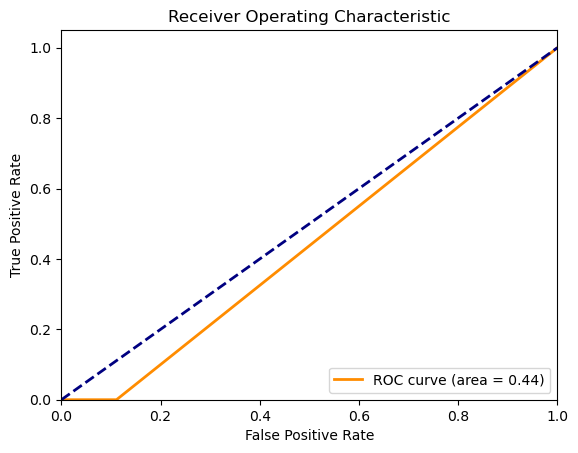

In [675]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('ROC-AUC:', roc_auc)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

This ROC-AUC curve is very poor. Would `sklearn`'s build-in `StackingClassifier` be any better?

`StackingClassifier` from `sklearn`

Validation Accuracy: 47.83%
Confusion Matrix - Validation Set:
[[ 1 12]
 [ 0 10]]
Classification Report - Validation Set:
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.45      1.00      0.62        10

    accuracy                           0.48        23
   macro avg       0.73      0.54      0.38        23
weighted avg       0.76      0.48      0.35        23

Test Accuracy: 30.77%
Confusion Matrix - Test Set:
[[1 8]
 [1 3]]
Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.27      0.75      0.40         4

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

ROC-AUC: 0.4305555555555556


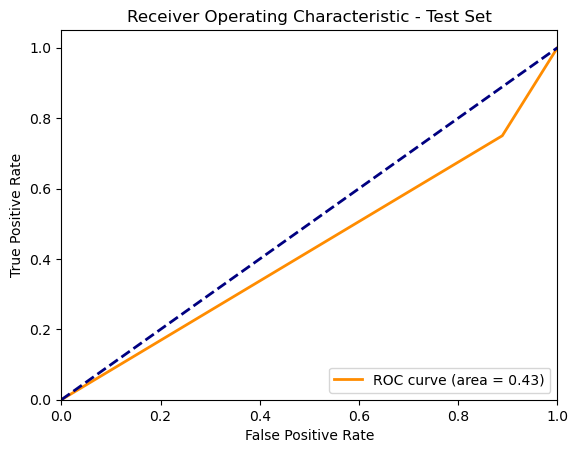

In [676]:
# define meta-classifier
meta_classifier = LogisticRegression()

# convert dict to list for StackingClassifier
classifiers_list = list(classifiers.items())

# create stacking classifier
stacked_clf = StackingClassifier(estimators=classifiers_list, final_estimator=meta_classifier)

# train stacking classifier on the training data
stacked_clf.fit(X_train, y_train)

# make predictions on the validation set
y_val_pred = stacked_clf.predict(X_val)

# evaluate the performance on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

# compute the confusion matrix for validation set
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
print(f'Confusion Matrix - Validation Set:\n{conf_matrix_val}')

# print the classification report for validation set
class_report_val = classification_report(y_val, y_val_pred)
print(f'Classification Report - Validation Set:\n{class_report_val}')

# finally, evaluate the stacked classifier on the test set
y_test_pred = stacked_clf.predict(X_test)

# compute accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

# compute confusion matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print(f'Confusion Matrix - Test Set:\n{conf_matrix_test}')

# print the classification report for test set
class_report_test = classification_report(y_test, y_test_pred)
print(f'Classification Report - Test Set:\n{class_report_test}')

# compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('ROC-AUC:', roc_auc)

# plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

I'm not sure why the accuracies are different, and the ROC curve is equally abysmal.

We're working with very few samples, so our precision, recall, accuracy, and ROC curve shows very poor performance. We will try a **voting** ensemble method next.

#### Voting (`hard` and `soft`) <a name='vote'></a>

We will try both hard and soft voting strategies.

ROC AUC score not available for Hard Voting.
=== Hard Voting ===
Accuracy: 30.77%
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.27      0.75      0.40         4

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13




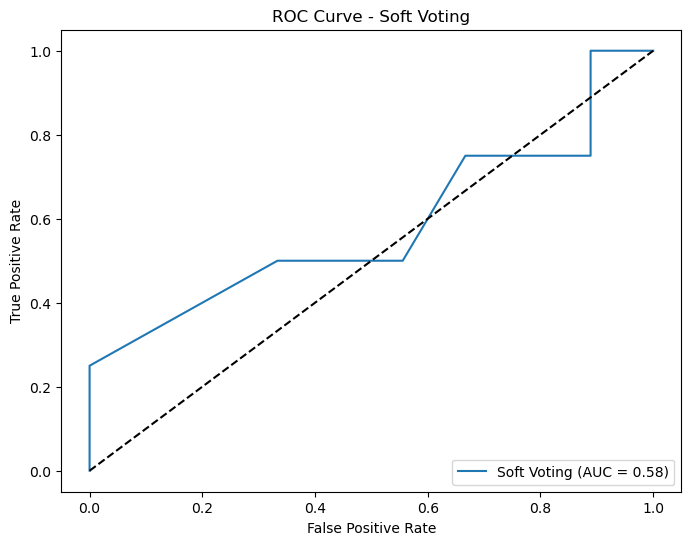

=== Soft Voting ===
Accuracy: 30.77%
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.27      0.75      0.40         4

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

ROC AUC Score: 0.58



In [682]:
# create a voting classifier for hard voting
hard_voting_clf = VotingClassifier(estimators=list(classifiers.items()), voting='hard')
hard_voting_clf.fit(X_train, y_train)

# create a voting classifier for soft voting
soft_voting_clf = VotingClassifier(estimators=list(classifiers.items()), voting='soft')
soft_voting_clf.fit(X_train, y_train)

# evaluate both voting classifiers
for clf_name, clf in [('Hard Voting', hard_voting_clf), ('Soft Voting', soft_voting_clf)]:
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    try:
        y_scores = clf.predict_proba(X_test)[:, 1]  # For classifiers that support predict_proba
        roc_auc = roc_auc_score(y_test, y_scores)
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {clf_name}')
        plt.legend(loc='lower right')
        plt.show()
        
    except AttributeError:
        roc_auc = None
        print(f"ROC AUC score not available for {clf_name}.")
    
    print(f"=== {clf_name} ===")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print("Classification Report:\n", report)
    if roc_auc is not None:
        print(f"ROC AUC Score: {roc_auc:.2f}")
    print("=================\n")

Voting did not perform well either, thought the curve is marginally better.

## Conclusion <a name='conclusion'></a>

### Reviewing the task <a name='review'></a>

My task for this project was to predict customer happiness based on the results of a survey, provided by a food delivery company. In addition to their final answers (whether they were satisfied or not), I was given six columns of responses:
* X1: Order was delivered on time
* X2: Contents of the order was as expected
> Think: after the order has been delivered
* X3: I ordered everything that I wanted to order
> Think: while placing the order
* X4: I paid a good price for my order
* X5: I am satisfied with my courier
* X6: The app makes ordering easy for me

The company wanted me to build a model that had an accuracy of 73% or higher. If I can't reach that number, I was told to explain why my solution is superior.

A stretch goal would be to determine which features were more important in predicting customer's happiness, so that they company could save time in completing a future survey.

### EDA Recap <a name='eda_review'></a>

In the dataset that I was given, 54.76% of the respondents were happy (n=69). 57 respondents were unhappy. This was my north star, in that I was trying to build models that would improve upon this base rate of about 55%.

Note that there were 126 observations in total. This will become very important as I explain my modeling strategy and exploration.

### Modeling Recap <a name='model_review'></a>

#### Feature engineering <a name='feature'></a>

To begin, I discretized the features into binary, so that if the respondents scored a 4 or a 5, I would label that a 1; otherwise, it would be 0. I called this the "thresholded" data. This would simplify the analysis for the models.

#### Modeling exploration: `LazyClassifier` <a name='lazy_review'></a>

To kick-off the modeling, I ran a `LazyClassifier` search to help me narrow down which algorithms would be better suited for the task. What quickly became apparent, however, was that given the size of the dataset, randomness controlled which models were the best. This would also continue to pose a big challenge for me as I started running the models and tuning them.

I explored how randomness and test size fractions controlled accuracy as a sidenote. The take-home message here is that randomness and test size fractions play a huge role in small datasets.

#### Focused modeling exploration on different versions of the dataset <a name='focus'></a>

Next, I compared the thresholded (aka discretized into binary) generic modeling accuracy to what the accuracy would be for regular and OneHotEncoded versions of the dataset. I did this for the following algorithms, as they usually scored high in the `LazyClassifier` exploration.
* `XGBClassifier`
* `LGBMClassifier`
* `DecisionTreeClassifier`
* `QuadraticDiscriminantAnalysis`

The accuracies were all over the place. Sometimes I achieved a 77% accuracy, only to rerun it with a new random seed and watch the accuracy fall to the mid 40's.

#### `Hyperopt` <a name='hyperopt_review'></a>

After this, I thought I would do a better version of the `GridSearchCV` tool in `sklearn`: `Hyperopt`. I used `RFE` to select a subset of the features so as to get at the stretch goal of the company. I ran `Hyperopt` with the following algorithms, though `RFE` was not used for the `LogisticRegression` classifiers. When applicable, I chose to define the search space to include many shallow estimators rather than deep trees. This would help limit overfitting while keeping the search speed and efficiency high.
* `ExtraTreesClassifier`
* `XGBoost`
* `DecisionTreeClassifier`
* `RandomForestClassifier`
* `LGBMClassifier`
* `LogisticRegression`, searching through all relevant solvers
* `LogisticRegression`, searching with just the `liblinear` solver  

The results of `Hyperopt` were also disappointing. The feature selection using RFE was not consistent either.

That being said, there was one more idea I had, and it could use the hyperparameter tuning that I had `Hyperopt` perform: Stacking and Voting ensembling methods.

#### Stacking and Voting <a name='ens_review'></a>

By combining the outputs of the models together into a metamodel, we could potentially achieve a better accuracy. 
* The stacking method had better results than the voting method
> They were still not great, as the accuracies were in the low 60s.  
> This is equal to if not better than the other methods we tried previously. 
* I trust the results from the stacking classifier more as it is a true ensembling of many different models that have each been tuned to the best of my ability.

### Final thoughts <a name='fin'></a>

If we take a step back, my role was to help the company improve their service quality. With about half the respondents unhappy, we can say that the opportunities to improve the company's services was very high. What specifically about their delivery service made people happy, and what didn't? Although I can't confidently say which component of their service was fundamentally the strongest and which was the weakest, we can say that:
* The company's **delivery time** elicited the **highest average satisfaction**
* Upon opening their order, the customers rated the **contents of the order** the **worst average satisfaction**

The results of our modeling show:
* The low number of observations have a big effect on the modeling and feature elimination was not conclusive  
* That being said, we were able to improve upon the baseline accuracy **from about 55%** to **over 60%**.

I suggest that the company:
* Continue to have good delivery times
* Ensure that the contents of the order are what the customer wanted
* The company would do well to **gather more survey responses**, which would **help improve the performance of the models**

<mark>  _**A question for the reader: What algorithms are best for small datasets? What should I try next?**_ </mark>